In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(206)
import theano
import theano.tensor as tt
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

In [2]:
X = np.linspace(0,2,200)[:,None]

def plot_cov(X, K, stationary=True):
    x = X.flatten()
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(121)
    m = ax1.imshow(K, cmap="viridis", interpolation='none'); plt.colorbar(m)
    ax2 = fig.add_subplot(122)
    
    if not stationary:
        ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax2.set_title("The Diagonal of K")
    else:
        ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax2.set_title("K as a function of x - x'")
    
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(111)
    ax.plot(x, np.random.multivariate_normal(np.zeros(200), K, 10).T);

# Current covariance functions / kernels

#### Allowed operations:
- Products and sums of covariance functions
- Product and sum of a scalar (a PyMC3 variable) and a covariance function
- Sum/product of a precomputed matrix and a covariance function

## Exponentiated Quadratic

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: covariance is not positive-semidefinite.


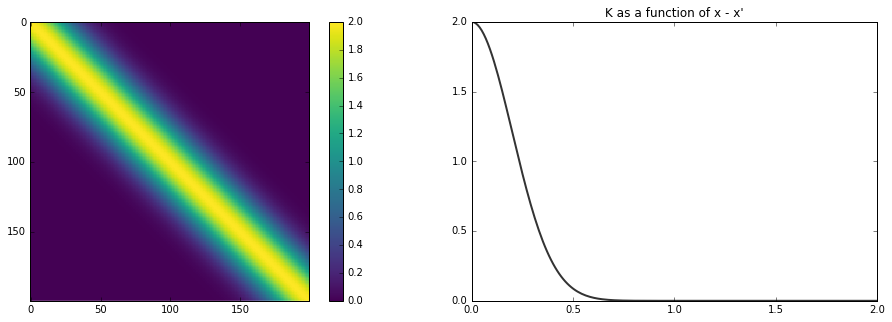

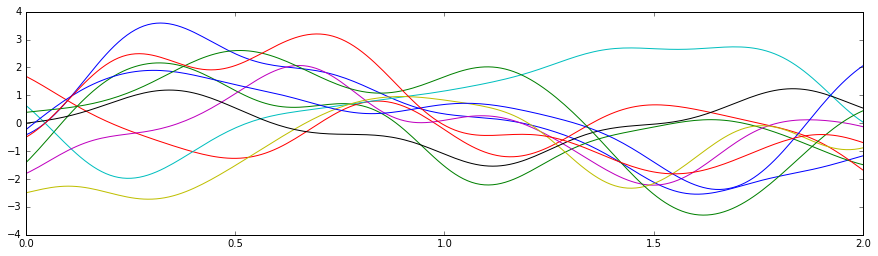

In [3]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0 
    cov = tau * pm.gp.cov.ExpQuad(1, l)

K = theano.function([], cov.K(X))()
plot_cov(X, K)

# Two (and higher) Dimensional Inputs
## Both dimensions active

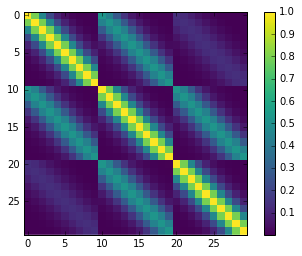

In [4]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

with pm.Model() as model:
    l = np.array([0.2, 1.0])
    cov = pm.gp.cov.Matern52(2, l)
K = theano.function([], cov.K(X2))()
m = plt.imshow(K, cmap="viridis", interpolation='none'); plt.colorbar(m);

## One dimension active

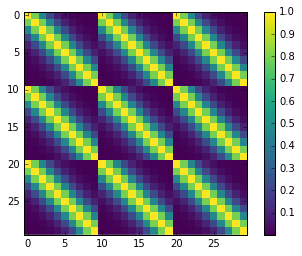

In [5]:
with pm.Model() as model:
    l = 0.2
    cov = pm.gp.cov.Matern52(2, l, active_dims=[True, False])
K = theano.function([], cov.K(X2))()
m = plt.imshow(K, cmap="viridis", interpolation='none'); plt.colorbar(m);

## Product of two covariances, active over each dimension

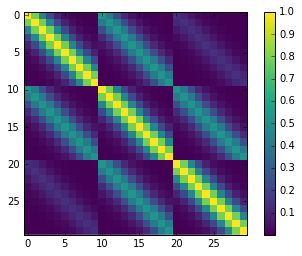

In [6]:
with pm.Model() as model:
    l1 = 0.2
    l2 = 1.0
    cov1 = pm.gp.cov.Matern52(2, l1, active_dims=[True, False])
    cov2 = pm.gp.cov.Matern52(2, l2, active_dims=[False, True])
    cov = cov1 * cov2
K = theano.function([], cov.K(X2))()
m = plt.imshow(K, cmap="viridis", interpolation='none'); plt.colorbar(m);

## Rational Quadratic

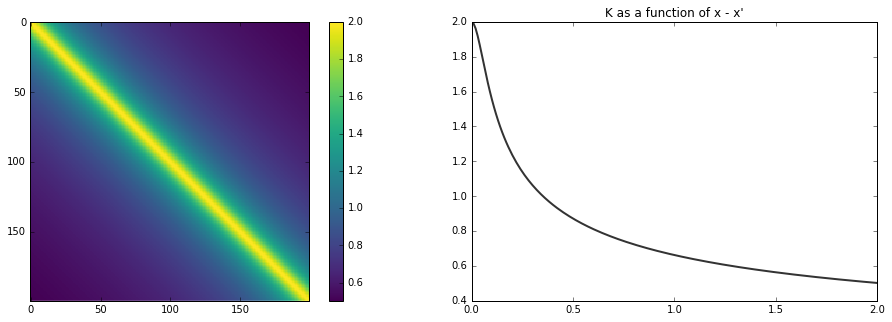

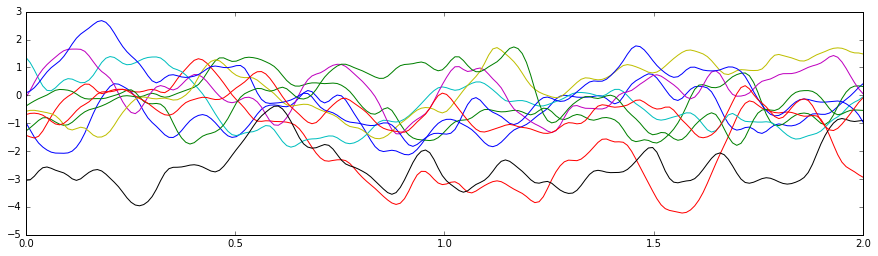

In [7]:
with pm.Model() as model:
    alpha = 0.2
    l = 0.1
    tau = 2.0
    cov = tau * pm.gp.cov.RatQuad(1, l, alpha)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Exponential

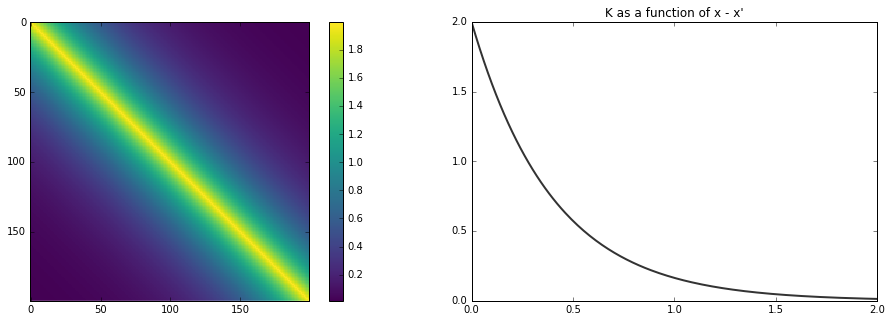

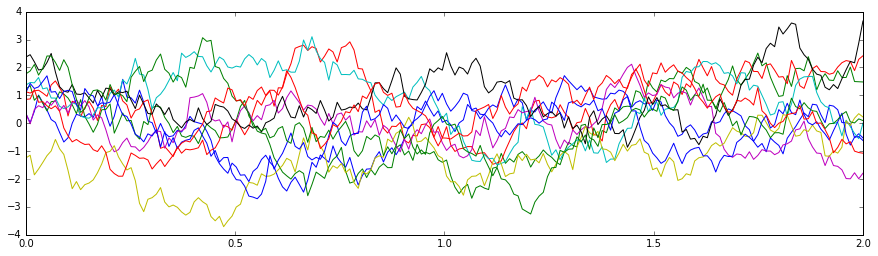

In [8]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Exponential(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Matern 5/2

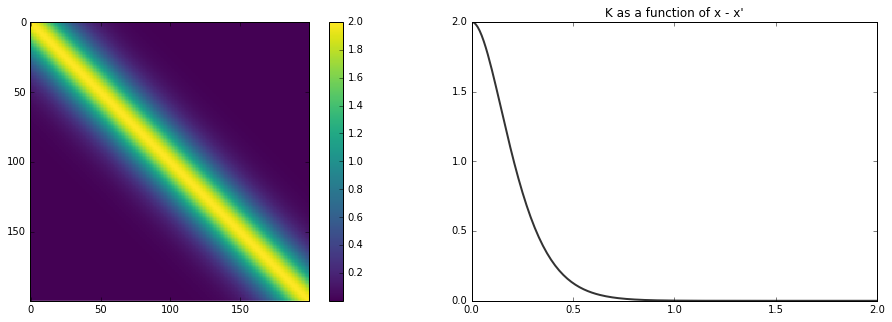

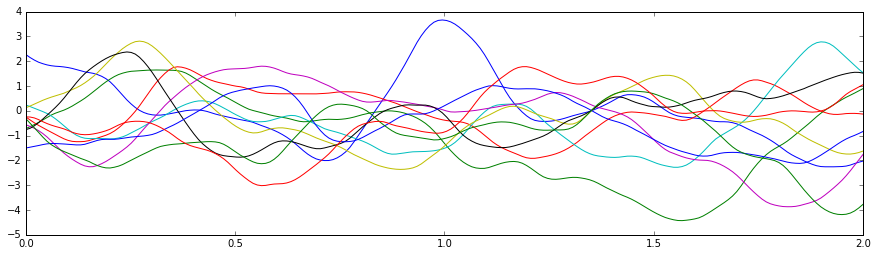

In [9]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern52(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Matern 3/2

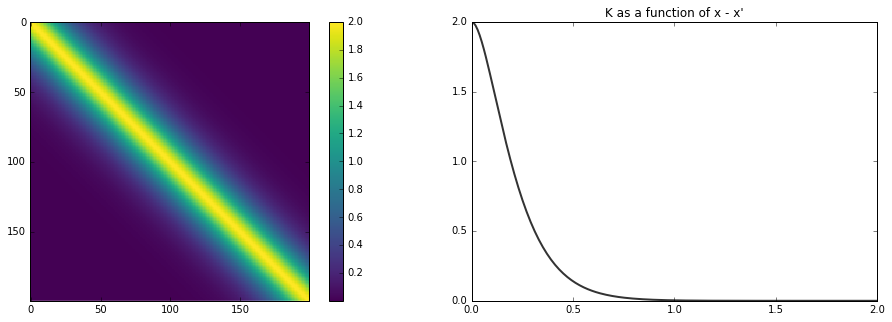

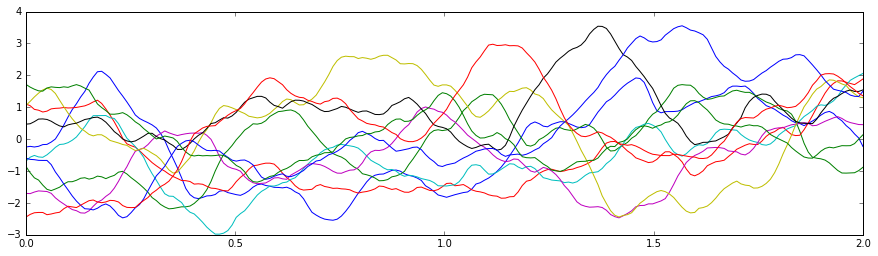

In [10]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

# Cosine

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: covariance is not positive-semidefinite.


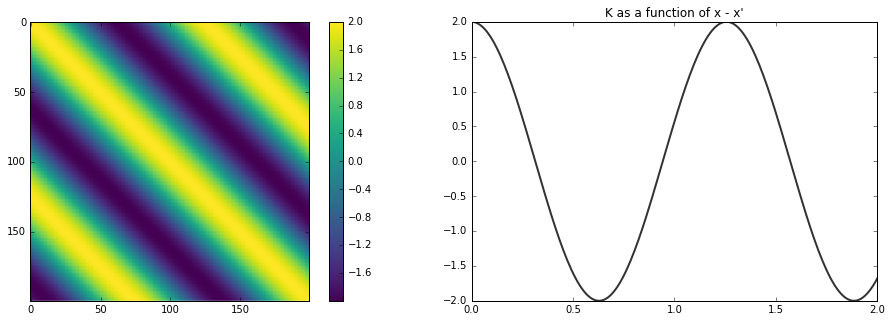

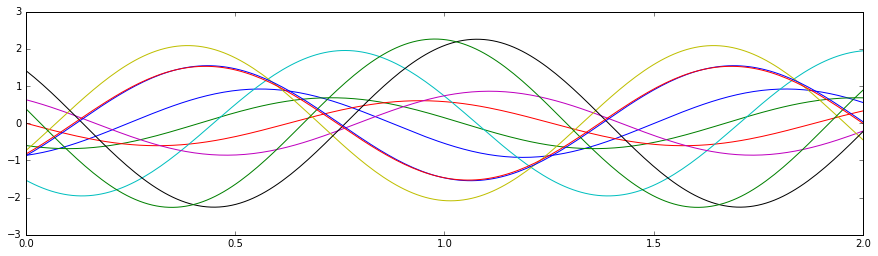

In [11]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

# Linear

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: covariance is not positive-semidefinite.


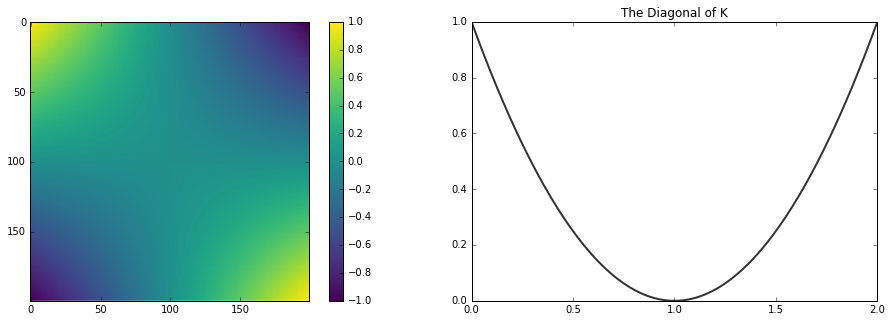

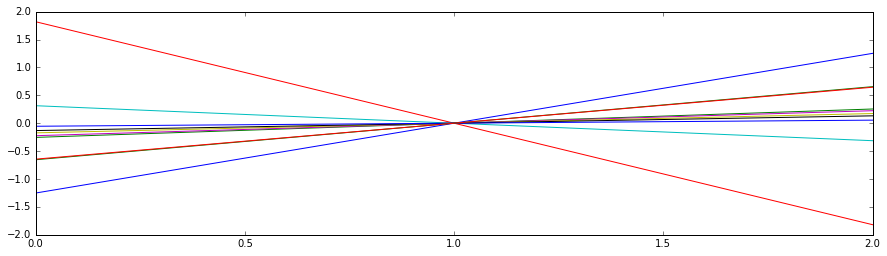

In [12]:
with pm.Model() as model:
    center = 1.0
    slope = 2.0
    tau = 1.0
    cov = tau * pm.gp.cov.Linear(1, center)

K = theano.function([], cov.K(X))()

plot_cov(X, K, False)

# Multiplication with a precomputed covariance matrix 

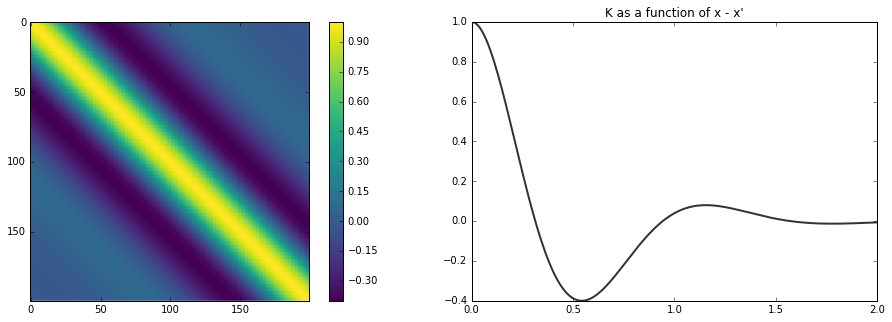

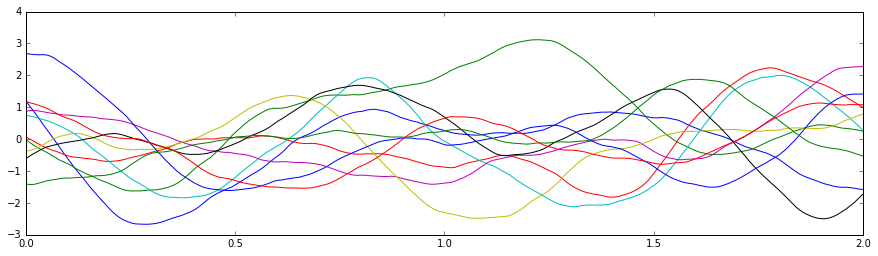

In [13]:
with pm.Model() as model:
    l = 0.2
    cov_cos = pm.gp.cov.Cosine(1, l)
K_cos = theano.function([], cov_cos.K(X))()

    
with pm.Model() as model:
    cov = tau * pm.gp.cov.Matern32(1, 0.5) * K_cos
    
K = theano.function([], cov.K(X))()
plot_cov(X, K)

# Applying an arbitary warping function on the inputs

If $k(x, x')$ is a valid covariance function, then so is $k(w(x), w(x'))$.

The warping function can have unknown parameters.

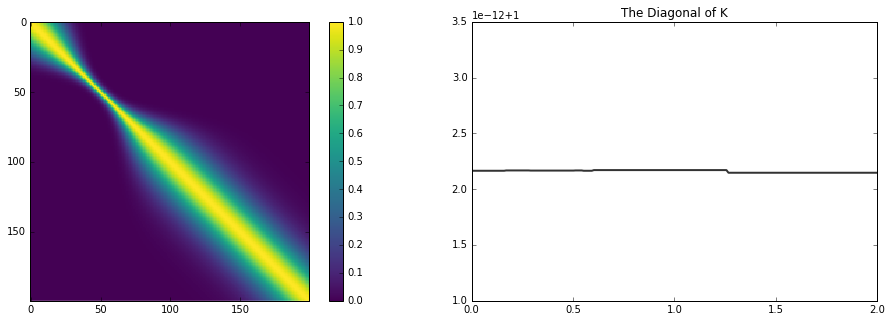

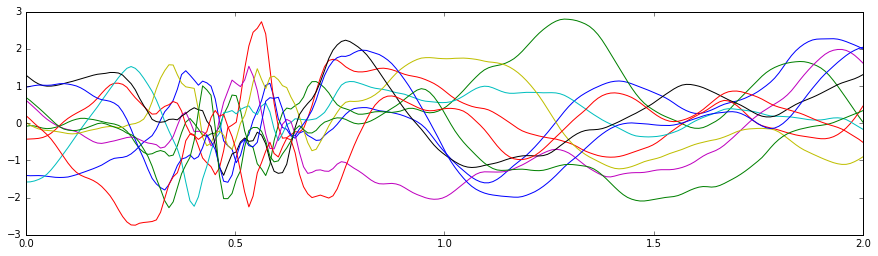

In [14]:
def warp_func(x, a, b, c):
    return x + (a * tt.tanh(b * (x + c)))

with pm.Model() as model:
    a = 1.0
    b = 6.0
    c = -0.5
    
    cov_m52 = pm.gp.cov.Matern52(1, l)
    cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a,b,c), cov_func=cov_m52)
    
K = theano.function([], cov.K(X))()
plot_cov(X, K, False)

# Covariance function via a (fixed, for now) basis

Since the basis is fixed, this covariance raises an error when called 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: covariance is not positive-semidefinite.


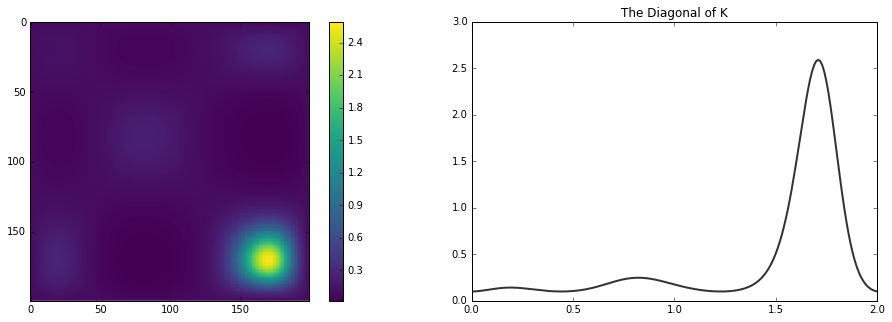

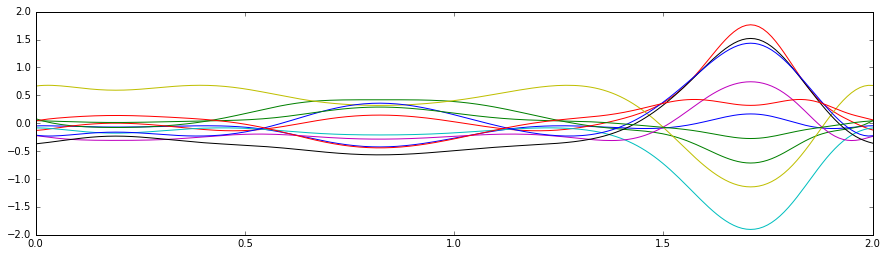

In [15]:
import patsy as pt
basis = np.array(pt.dmatrix("bs(x, 5) - 1", {"x": X}))

with pm.Model() as model:
    alpha = np.array([[1.5, -2.0, 0.1, 3.0, 0.1]]).T
    tau = 0.1
    cov = tau * pm.gp.cov.BasisFuncCov(1, basis=basis, alpha=alpha)

K = theano.function([], cov.K(X))()
plot_cov(X, K, False)